In [1]:
from drn_interactions.load import load_neurons_derived, load_derived_generic
from drn_interactions.spikes import SpikesHandler
from drn_interactions.brain_state_decode import StateDecoder, StateDecodeDataLoader, StateDecodePreprocessor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from drn_interactions.brain_state_decode import shuffle_X


from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import numpy as np
import pandas as pd
sns.set_theme(context="poster", style="ticks")

from IPython.display import display

%load_ext autoreload
%autoreload 2

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
def eeg_decode(
    loader: StateDecodeDataLoader,
    preprocessor:StateDecodePreprocessor,
    decoder: StateDecoder,
    nboot = 75,
    ):
    spikes, states = loader()
    spikes, states = preprocessor(spikes, states)
    
    pop_true = np.mean(decoder.get_real_scores(spikes, states))
    pop_reps = decoder.get_bootstrap_scores(spikes, states, n_boot=nboot)
    pop_shuffle = np.mean(pop_reps, axis=1).mean()
    out_pop = pd.DataFrame({"true": pop_true, "shuffle": pop_shuffle}, index=[0]) 
    
    unit_scores = decoder.get_unit_scores(spikes, states)
    out_unit = pd.DataFrame(unit_scores).mean().to_frame("F1 Score").reset_index().rename(columns=dict(index="neuron_id"))

    return out_pop, out_unit

def eeg_decode_multi(sessions, loader, preprocessor, decoder, nboot=75):
    out_pop = []
    out_unit = []
    for session in sessions:
        print(session) 
        loader_session = deepcopy(loader)
        loader_session.set_session(session)
        pop, unit = eeg_decode(loader_session, preprocessor, decoder, nboot)
        pop = pop.assign(session_name=session)
        unit = unit.assign(session_name=session)
        out_pop.append(pop)
        out_unit.append(unit)
    return pd.concat(out_pop).reset_index(drop=True), pd.concat(out_unit).reset_index(drop=True)

In [3]:
eeg_states = load_derived_generic("eeg_states.csv").rename(columns={"cluster": "state"})
neurons = load_neurons_derived()
sessions = neurons.merge(eeg_states[["session_name"]].drop_duplicates(), on="session_name")["session_name"].unique()


In [4]:
loader =StateDecodeDataLoader(
    session_name=None,
    block="pre",
    t_start=0,
    t_stop=1800,
    bin_width=1,
    )
preprocessor = StateDecodePreprocessor(thresh_empty=2)
pipe = RandomForestClassifier()
cv = KFold(shuffle=True)
decoder = StateDecoder(
    estimator=pipe,
    cv=cv,
    shuffler=shuffle_X
)
pop, unit = eeg_decode_multi(sessions, loader, preprocessor, decoder, nboot=2)

ESHOCK_03_LOC1


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


ESHOCK_04_LOC1


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


ESHOCK_06_LOC1


100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


ESHOCK_07_LOC1


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


ESHOCK_08_LOC1


100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


ESHOCK_09_LOC1


100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


hamilton_10


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


hamilton_03


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


hamilton_04


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


hamilton_09


100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


acute_15


100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


acute_16


100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


acute_14


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


acute_12


100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


acute_11


100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


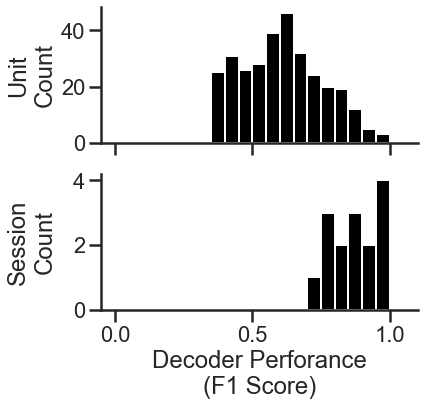

In [5]:
f, axes = plt.subplots(2, figsize=(6, 5), sharex=True)

bins = np.arange(0, 1.1, 0.05)

axes[0].hist(unit["F1 Score"], color="black", bins=bins, density=False)
sns.despine()
axes[0].set_ylabel("Unit\nCount")
plt.tight_layout()

axes[1].hist(pop["true"], color="black", bins=bins, density=False)
sns.despine()
axes[1].set_xlabel("Decoder Perforance\n(F1 Score)")
axes[1].set_ylabel("Session\nCount")
f.align_ylabels()

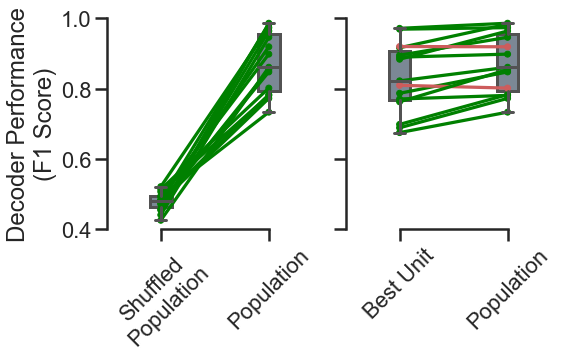

In [6]:
df = (
    unit.merge(neurons)
    .groupby("session_name")["F1 Score"]
    .max()
    .to_frame("best_neuron")
    .reset_index()
    .merge(pop)
)

fig, ax = plt.subplots(ncols=2, figsize=(8, 5), sharey=True)

ax0 = ax[0]
df1 =  pop.melt(id_vars="session_name")

ax0.set_ylim(0.4, 1)
ax0.set_yticks([0.4, 0.6, 0.8, 1])
pg.plot_paired(data=df1, dv='value', within='variable',
               subject='session_name', ax=ax0, boxplot=True,
               )
ax0.set_xlabel(None)
ax0.set_ylabel("Decoder Performance\n(F1 Score)")

ax0.set_xticklabels(["Shuffled\nPopulation", "Population"],  rotation=45)


ax1 = ax[1]
df1 =  df.drop("shuffle", axis=1).melt(id_vars="session_name")

pg.plot_paired(data=df1, dv='value', within='variable',
               subject='session_name', ax=ax1, boxplot=True,
               )
ax1.set_xlabel(None)
ax1.set_ylabel("Decoder Performance\n[F1 Score]")
ax1.set_xticklabels(["Best Unit", "Population"], rotation=45)

plt.tight_layout()